Do movies featuring a Best Actor or Best Actress winner in their cast tend to perform better?

In [466]:
import requests
import json
import time
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ast
import statsmodels.formula.api as smf
import matplotlib.ticker as mticker

In [467]:
# Import TMDB data including best picture movies
tmdb_data = pd.read_csv(f'../data/movies_issue_10.csv').drop_duplicates(subset=['Title','Year'])

# Import best actor data
best_actor = pd.read_csv('../data/best_actor.csv')
best_actress = pd.read_csv('../data/best_actress.csv')
# Combine actor and actress data
best_actors = pd.concat([best_actor,best_actress])
best_actors = best_actors.rename(columns={'Film_Title':'Title'})

In [468]:
# Merge best actor data and TMDB API data into a single DataFrame
movies_df = best_actors.merge(tmdb_data, how='outer', on=['Title','Year'])

# Filter to just 2015-2024
movies_df = movies_df[movies_df['Year']>=2015]

# Fill NaN values
values = {'Winner': 'No', 'Nominated': 'No'}
movies_df = movies_df.fillna(value=values)

In [469]:
# Converting financial data to 2024 dollars 
# Store CPI values 
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')

budget_2024 = []
for year,budget in zip(movies_df['Year'], movies_df['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)

# Reassign adjusted budget numbers to the Budget column
movies_df['Budget'] = budget_2024

revenue_2024 = []
for year,revenue in zip(movies_df['Year'], movies_df['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)

# Reassign adjusted budget numbers to the Revenue column
movies_df['Revenue'] = revenue_2024

In [470]:
len(movies_df)

1046

In [471]:
# Filter out rows where revenue is 0
movies_df = movies_df[~((movies_df['Revenue'].round() == 0.0) | (movies_df['Budget'].round() == 0.0))]

In [472]:
len(movies_df)

831

In [473]:
# Creating Oscar status column
movies_df['Nominated'] = movies_df['Nominated'].replace({'Yes':True, 'No':False})
movies_df['Winner'] = movies_df['Winner'].replace({'Yes':True, 'No':False})
movies_df['Oscar_Status'] = movies_df['Nominated'].astype(int) + movies_df['Winner'].astype(int)
movies_df['Oscar_Status'] = movies_df['Oscar_Status'].astype(int).replace({0: 'Not Nominated', 1: 'Nominated', 2: 'Winner'})

/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_16823/2222639873.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_df['Nominated'] = movies_df['Nominated'].replace({'Yes':True, 'No':False})
/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_16823/2222639873.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movies_df['Winner'] = movies_df['Winner'].replace({'Yes':True, 'No':False})


In [474]:
movies_df

,Year,Actor_Name,Title,Winner,Nominated,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Oscar_Status
0,2020,NaN,#Alive,False,False,"['Action', 'Horror', 'Science Fiction']",7.228,1956.0,7.635845e+06,1.626106e+07,614696.0,Not Nominated
2,2016,NaN,10 Cloverfield Lane,False,False,"['Thriller', 'Science Fiction', 'Drama', 'Horr...",6.994,8359.0,1.960499e+07,1.440535e+08,333371.0,Not Nominated
3,2018,NaN,12 Strong,False,False,"['War', 'Drama', 'Action', 'History']",6.346,3097.0,4.372286e+07,8.426121e+07,429351.0,Not Nominated
6,2016,NaN,13 Hours: The Secret Soldiers of Benghazi,False,False,"['War', 'Action', 'History', 'Drama', 'Thriller']",7.269,3789.0,6.534997e+07,9.072062e+07,300671.0,Not Nominated
7,2019,NaN,1917,False,False,"['War', 'History', 'Drama', 'Action']",8.000,13092.0,1.226992e+08,5.473172e+08,530915.0,Not Nominated
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2015,NaN,Youth,False,False,"['Comedy', 'Drama', 'Romance']",6.900,2144.0,1.768179e+07,2.646975e+06,310593.0,Not Nominated
1906,2019,NaN,Zombieland: Double Tap,False,False,"['Horror', 'Comedy']",6.912,6022.0,5.153365e+07,1.506873e+08,338967.0,Not Nominated
1907,2016,NaN,Zootopia,False,False,"['Animation', 'Adventure', 'Family', 'Comedy']",7.800,17070.0,1.960499e+08,1.340356e+09,269149.0,Not Nominated
1909,2017,NaN,mother!,False,False,"['Drama', 'Horror']",6.967,6911.0,3.839209e+07,5.697003e+07,381283.0,Not Nominated


In [475]:
movies_df['Revenue_Millions'] = (movies_df['Revenue'] / 1000000)
median_rev_oscar_status=movies_df.groupby('Oscar_Status')['Revenue_Millions'].median().reset_index()
median_rev_oscar_status_reordered = median_rev_oscar_status.iloc[[1,0,2],:]

In [476]:
median_rev_oscar_status

,Oscar_Status,Revenue_Millions
0,Nominated,53.299661
1,Not Nominated,146.785136
2,Winner,120.449929


In [477]:
median_rev_oscar_status_reordered

,Oscar_Status,Revenue_Millions
1,Not Nominated,146.785136
0,Nominated,53.299661
2,Winner,120.449929


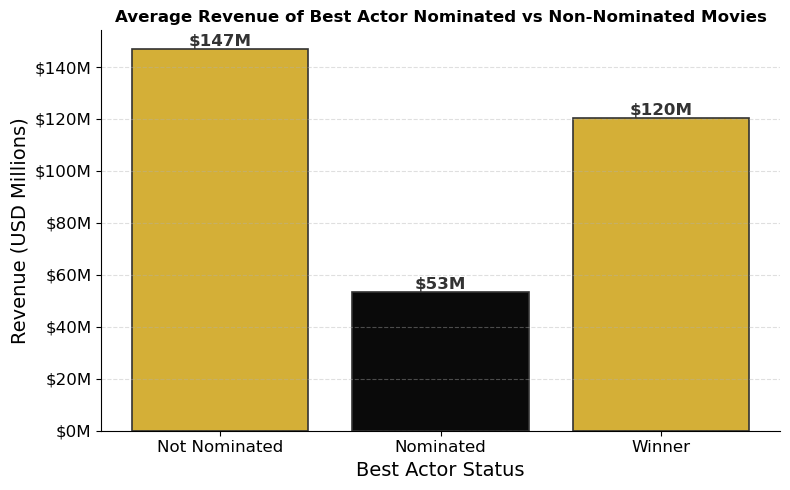

In [478]:
fig, ax = plt.subplots(figsize=(8, 5))

# Oscar-themed colors (matte black + metallic gold)
colors = ['#D4AF37', '#0A0A0A']   # deep black + Oscar gold
# Plot
bars = ax.bar(
    median_rev_oscar_status_reordered['Oscar_Status'],
    median_rev_oscar_status_reordered['Revenue_Millions'],
    color=colors,
    edgecolor='#333333',
    linewidth=1.2
)
# Format y-axis as dollars
ax.yaxis.set_major_formatter(
    mticker.StrMethodFormatter('${x:,.0f}M')
)
# Value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'${height:,.0f}M',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='#333333'
    )
# Title and labels
ax.set_title(
    'Average Revenue of Best Actor Nominated vs Non-Nominated Movies',
    fontsize=12,
    fontweight='bold'
)
ax.set_xlabel('Best Actor Status', fontsize=14)
ax.set_ylabel('Revenue (USD Millions)', fontsize=14)
# Style tweaks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(
    '../assets/Average_Revenue_by_Best_Actor_Status',
    dpi=150
)
plt.show()

In [479]:
# Narrowing down to just Dramas
movies_df = movies_df.dropna(subset=['Genre'])
#Average revenue for a drama with a best actor/actress winner in the cast
bestactor_profit = movies_df[(movies_df['Winner']==True)
                                & (movies_df['Genre'].str.contains('Drama'))]['Revenue'].median()

#Average revenue for a drama with a nominated best actor/actress in the cast (who did not win)
nominee_profit = movies_df[(movies_df['Winner']==False) 
                                & (movies_df['Nominated']==True)
                                & (movies_df['Genre'].str.contains('Drama'))]['Revenue'].median()

#Average revenue for a drama without a best actor/actress winner or nominee in the cast
no_nominee_profit = movies_df[(movies_df['Winner']==False) 
                                & (movies_df['Nominated']==False)
                                & (movies_df['Genre'].str.contains('Drama'))]['Revenue'].median()

In [480]:
print(f'The average revenue for a drama with a best actor/actress winner in the cast is ${bestactor_profit:,.2f}.')

The average revenue for a drama with a best actor/actress winner in the cast is $111,538,471.09.


In [481]:
print(f'The average revenue for a drama with a best actor/actress nominee (but not winner) in the cast is ${nominee_profit:,.2f}.')

The average revenue for a drama with a best actor/actress nominee (but not winner) in the cast is $53,299,661.02.


In [482]:
print(f'The average revenue for a drama without a best actor/actress winner or nominee in the cast is ${no_nominee_profit:,.2f}.')

The average revenue for a drama without a best actor/actress winner or nominee in the cast is $62,007,844.72.


In [483]:
# Narrowing down to just dramas
median_rev_oscar_status=movies_df[movies_df['Genre'].str.contains('Drama')].groupby('Oscar_Status')['Revenue_Millions'].median().reset_index()
median_rev_oscar_status_reordered = median_rev_oscar_status.iloc[[1,0,2],:]

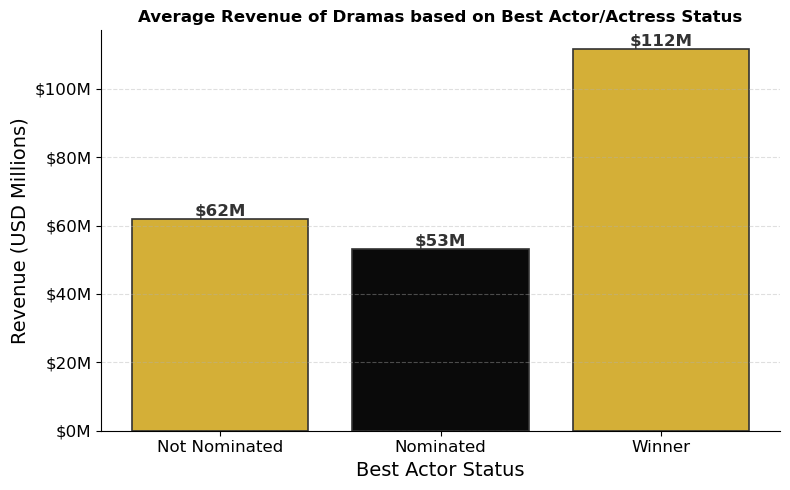

In [484]:
fig, ax = plt.subplots(figsize=(8, 5))

# Oscar-themed colors (matte black + metallic gold)
colors = ['#D4AF37', '#0A0A0A']   # deep black + Oscar gold
# Plot
bars = ax.bar(
    median_rev_oscar_status_reordered['Oscar_Status'],
    median_rev_oscar_status_reordered['Revenue_Millions'],
    color=colors,
    edgecolor='#333333',
    linewidth=1.2
)
# Format y-axis as dollars
ax.yaxis.set_major_formatter(
    mticker.StrMethodFormatter('${x:,.0f}M')
)
# Value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'${height:,.0f}M',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='#333333'
    )
# Title and labels
ax.set_title(
    'Average Revenue of Dramas based on Best Actor/Actress Status',
    fontsize=12,
    fontweight='bold'
)
ax.set_xlabel('Best Actor Status', fontsize=14)
ax.set_ylabel('Revenue (USD Millions)', fontsize=14)
# Style tweaks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(
    '../assets/Average_Revenue_by_Best_Actor_Status_Drama',
    dpi=150
)
plt.show()

In [485]:
# Linear model showing the effect of best actor status on revenue
# Convert Genre column to list type so that it can be exploded
movies_df['Genre'] = movies_df['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

# Explode the movies_df DataFrame by genre
movies_df_exploded = movies_df.explode('Genre')

# Create an indicator variable for each genre
genre_dummies = pd.get_dummies(movies_df_exploded['Genre'], prefix='genre')

# Group the genre indicator variables so that we have 1 row per movie
genre_dummies_grouped = genre_dummies.groupby(level=0).max()
# Replace spaces in column names with underscores
genre_dummies_grouped.columns = [column.replace(' ','_') for column in genre_dummies_grouped.columns]

# Join the genre indicator variables to the movies_df DataFrame
movies_genre_indicator = movies_df.join(genre_dummies_grouped)

# Fitting a linear regression model for vote_average using years and each of the genre indicator variables
# Extract all of the genre indicator variables and concatenate them with plus signs to be used in the linear model
genre_indicators = [column for column in movies_genre_indicator.columns if 'genre_' in column]
genre_indicators = ' + '.join(genre_indicators)
revenue_model_with_genres = smf.ols(f"Revenue ~ C(Oscar_Status, Treatment('Not Nominated')) + {genre_indicators}", data = movies_genre_indicator).fit()
revenue_model_with_genres.summary()

/var/folders/51/zgq0lbb14t13h0_bgn8nntnm0000gn/T/ipykernel_16823/1356174244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['Genre'] = movies_df['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     13.29
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           1.56e-36
Time:                        14:55:07   Log-Likelihood:                -17299.
No. Observations:                 820   AIC:                         3.464e+04
Df Residuals:                     800   BIC:                         3.473e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                 2.422e+08   5.07e+07      4.778      0.000    1.43e+08    3.42e+08
C(Oscar_Status, Treatment('Not Nominated'))[T.Nominated]  4.597e+06   5.47e+07      0.084      0.933   -1.03e+08    1.12e+08
C(Oscar_Status, Treatment('Not Nominated'))[T.Winner]     1.823e+08    8.8e+07      2.071      0.039    9.49e+06    3.55e+08
genre_Action[T.True]                                      9.478e+07   3.65e+07      2.596      0.010    2.31e+07    1.66e+08
genre_Adventure[T.True]                                   1.816e+08   3.72e+07      4.885      0.000    1.09e+08    2.55e+08
genre_Animation[T.True]                                   5.297e+07    6.6e+07      0.803      0.422   -7.65e+07    1.82e+08
genre_Comedy[T.True]                                      -6.77e+07   3.45e+07     -1.961      0.050   -1.35e+08    6.02e+04
genre_Crime[T.True]                                       1.388e+07   4.18e+07      0.333      0.740   -6.81e+07    9.59e+07
genre_Drama[T.True]                                       -1.02e+08   3.85e+07     -2.648      0.008   -1.78e+08   -2.64e+07
genre_Family[T.True]                                      1.605e+08    6.3e+07      2.549      0.011    3.69e+07    2.84e+08
genre_Fantasy[T.True]                                    -4.143e+07   3.96e+07     -1.046      0.296   -1.19e+08    3.63e+07
genre_History[T.True]                                    -6.161e+07   5.51e+07     -1.118      0.264    -1.7e+08    4.65e+07
genre_Horror[T.True]                                     -8.872e+07    4.4e+07     -2.016      0.044   -1.75e+08   -2.33e+06
genre_Music[T.True]                                       7.913e+07    7.8e+07      1.014      0.311    -7.4e+07    2.32e+08
genre_Mystery[T.True]                                    -5.755e+07   4.61e+07     -1.249      0.212   -1.48e+08    3.29e+07
genre_Romance[T.True]                                     1.948e+07   4.53e+07      0.430      0.667   -6.94e+07    1.08e+08
genre_Science_Fiction[T.True]                             1.056e+08   3.66e+07      2.882      0.004    3.37e+07    1.77e+08
genre_Thriller[T.True]                                   -6.499e+07   3.47e+07     -1.870      0.062   -1.33e+08    3.21e+06
genre_War[T.True]                                        -3.814e+07   8.92e+07     -0.428      0.669   -2.13e+08    1.37e+08
genre_Western[T.True]                                    -9.384e+07   1.38e+08     -0.679      0.497   -3.65e+08    1.77e+08
==============================================================================
Omnibus:                      480.554   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Ber